(ch14:unsup)=
# Unsupervised learning

To start this section off, let's recreate our example data that we were using in {numref}`ch7:comm_detect`:

In [16]:
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE
import numpy as np

ns = [50, 40, 30]
B = [[0.6, 0.2, 0.2],
     [0.2, 0.6, 0.2],
     [0.2, 0.2, 0.6]]

np.random.seed(1234)
A = sbm(n=ns, p = B)

# the true community labels
z = [0 for i in range(0,ns[0])] + [1 for i in range(0, ns[1])] + [2 for i in range(0, ns[2])]
Xhat = ASE(n_components=3).fit(A).latent_left_

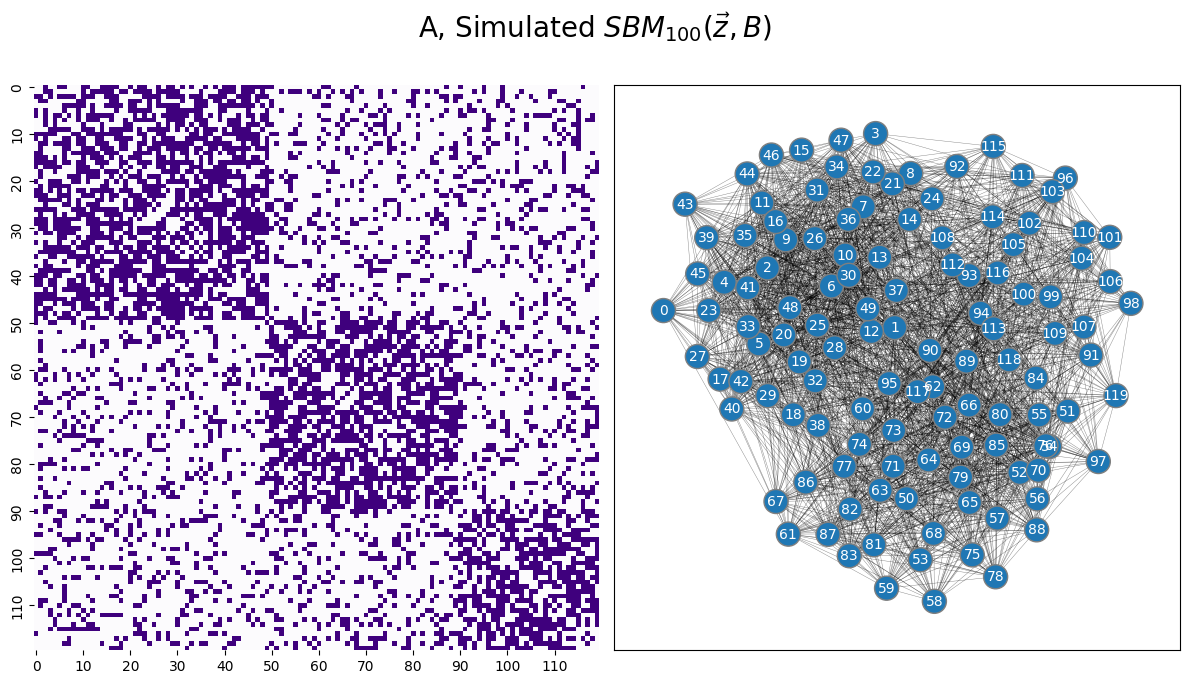

In [17]:
from graphbook_code import draw_multiplot, cmaps
draw_multiplot(A, xticklabels=10, yticklabels=10, title="A, Simulated $SBM_{100}( \\vec z, B)$");

(ch14:unsup:kmeans)=
## $k$-means clustering

To learn about these blobs, or more specifically, clusters in your dataset, you need a technique which will do the following:

+ Given: Estimates of latent positions, $\vec x_i$, for each node $i$ from $1$ to $n$, and a number of clusters to search for, $K$.
+ Output: Predicted labels $z_i$ for each node $i$ from $1$ to $n$.

The way you will do this is using an unsupervised clustering technique known as -means clustering. **Unsupervised learning** is the process of learning latent (unknown ahead of time) structure from a dataset. Our problem is unsupervised here because you do not give the algorithm any information as to the structure of which nodes are in which communities.

Through $k$-means, you try to find reasonable guesses at the "centers" of the blobs of latent structure in the dataset, and then find the closest center to a given point to predict a community label. You predict that the label of the point is the center which it is closest to. To do this, you first need a definition of close. Throughout this book, we've already come across one such definition which will do just fine for now: the Euclidean distance. Remember that the Euclidean distance between two points $\vec x_i$ and $\vec x_j$ which each have $d$-total dimensions is the quantity:
\begin{align*}
    ||\vec x_i - \vec x_j||_2 &= \sqrt{\sum_{l = 1}^d (x_{il} - x_{jl})^2}
\end{align*}

To illustrate what's happening graphically, we're going to take a look at a pairsplot of the second and third dimensions, and work through one loop of the $k$-means algorithm. The second and third dimensions look like this:

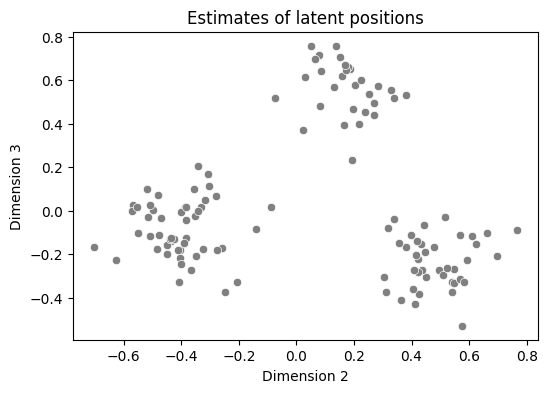

In [19]:
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

data = DataFrame({"Dimension 2" : Xhat[:,1], "Dimension 3" : Xhat[:,2]})
palette = {"0" : "blue", "1": "green", "2": "red"}
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(data=data, x="Dimension 2", y="Dimension 3", color="gray", ax=ax)
ax.set_title("Estimates of latent positions");

To perform $k$-means, you need a "starting point" for the centers you will attempt to identify. There are some strategies for doing this strategically (`sklearn`, for instance, uses one called `kmeans++`, which you can read about [on wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#initialization-methods)), but for our purposes we're going to put your centers in basically the worst possible locations: we'll put them smack dab in the middle of nowhere on your graph. This is problematic for $k$-means because of how the "update" step works, but as we'll see in a few minutes, this really isn't going to matter in practice for us:

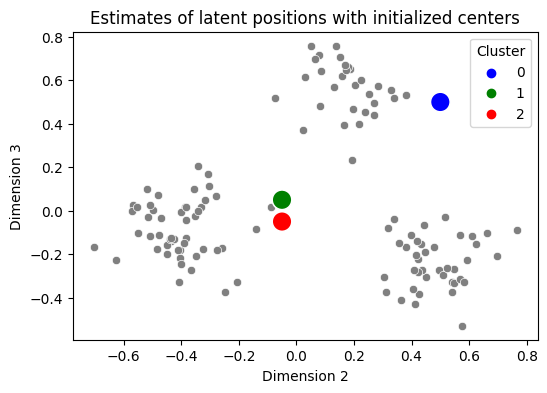

In [20]:
centers = np.array([[.5, .5], [-0.05, 0.05], [-0.05, -0.05]])
datcenters = DataFrame({"Dimension 2": centers[:,0], "Dimension 3": centers[:,1], "Cluster": ["0", "1","2"]})
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(data=data, x="Dimension 2", y="Dimension 3", color="gray", ax=ax)
sns.scatterplot(data=datcenters, x="Dimension 2", y="Dimension 3", hue="Cluster",
                palette=palette, ax=ax, s=200)
ax.set_title("Estimates of latent positions with initialized centers");

Next, what you do is you identify which points are "closest" to which cluster center. You do this by computing the distance between each estimate of a latent position and the three centers, and then decide which is the smallest. In the below plot, we recolor each gray point based on which of the centers it is closest to. This is called the points *assignment* to a particular cluster:

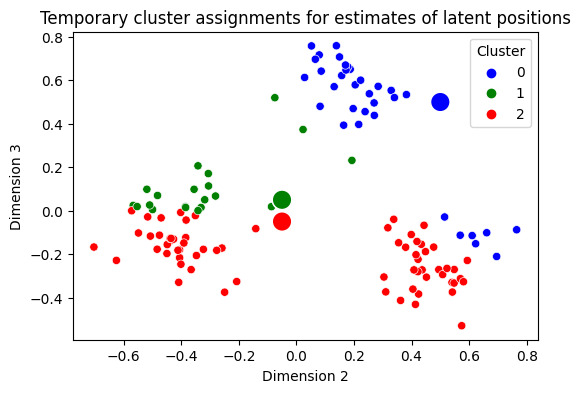

In [21]:
from scipy.spatial import distance_matrix
distances = distance_matrix(Xhat[:,1:3], centers)
assignment = np.argmin(distances, axis=1)

data["Closest Center"] = assignment.astype(str)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(data=data, x="Dimension 2", y="Dimension 3", hue="Closest Center", palette=palette,
                ax=ax, legend=False)
sns.scatterplot(data=datcenters, x="Dimension 2", y="Dimension 3", hue="Cluster", ax=ax, 
                palette=palette, s=200)
ax.set_title("Temporary cluster assignments for estimates of latent positions");

Which is not too bad! It looks like we've done a pretty good job at getting some of these blobs assigned to similar clusters when points are in the same blob, but you still have some problems. As you can see, some of your blobs have points which are really similar being colored differently, which is unideal. For this reason, we're going to do it all again!

Next, you *update* your centers, by taking the mean value (for each dimension) of the points which are assigned to that cluster. Our centers update like this:

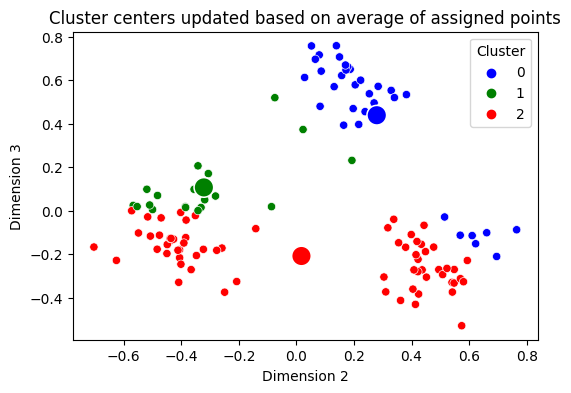

In [22]:
centers = np.array([np.mean(Xhat[assignment == k,1:3], axis=0) for k in range(0, 3)])

datcenters = DataFrame({"Dimension 2": centers[:,0], "Dimension 3": centers[:,1], "Cluster": ["0", "1","2"]})
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(data=data, x="Dimension 2", y="Dimension 3", hue="Closest Center", palette=palette,
                ax=ax, legend=False)
sns.scatterplot(data=datcenters, x="Dimension 2", y="Dimension 3", hue="Cluster",
                palette=palette, ax=ax, s=200)
ax.set_title("Cluster centers updated based on average of assigned points");

You can see where we're going with this, right? You assume again that the points are totally unlabeled (gray), you recompute which center each point is closest to, and then you re-update your centers. This is called the second *iteration* of the algorithm, because you are doing the exact same process a second time:

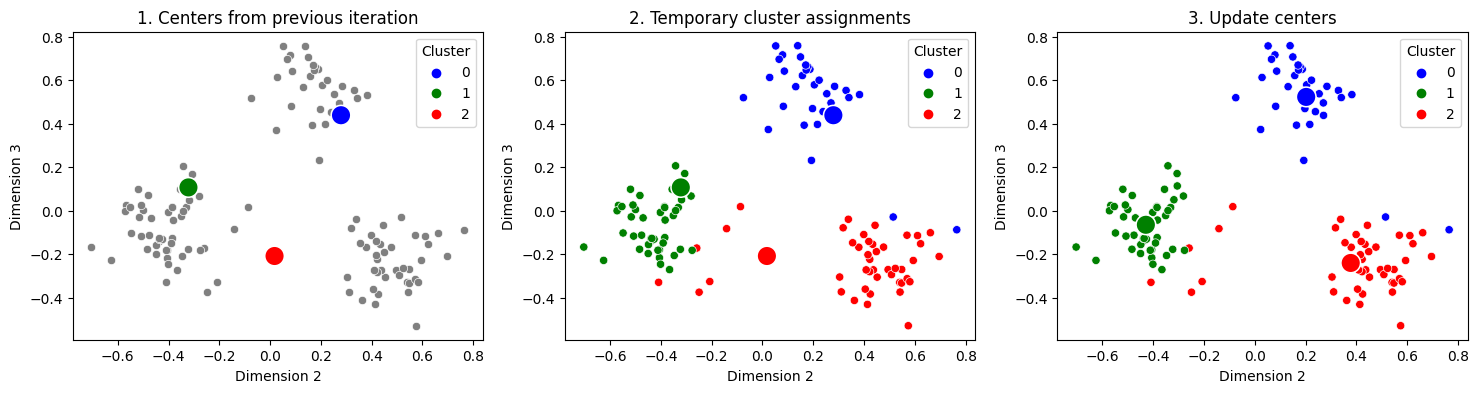

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
distances = distance_matrix(Xhat[:,1:3], centers)
assignment = np.argmin(distances, axis=1)
centers_new = np.array([np.mean(Xhat[assignment == k,1:3], axis=0) for k in range(0, 3)])

data["Closest Center"] = assignment.astype(str)

color_kwarg = [{"color": "gray"}, {"hue": "Closest Center"}, {"hue": "Closest Center"}]
cdat = [centers, centers, centers_new]
titles = ["1. Centers from previous iteration", "2. Temporary cluster assignments", "3. Update centers"]

for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=data, x="Dimension 2", y="Dimension 3", ax=ax, **color_kwarg[i],
                    palette=palette, legend=False)
    datcenters = DataFrame({"Dimension 2": cdat[i][:,0], "Dimension 3": cdat[i][:,1], "Cluster": ["0", "1","2"]})
    sns.scatterplot(data=datcenters, x="Dimension 2", y="Dimension 3", hue="Cluster",
                    palette=palette, ax=ax, s=200)
    ax.set_title(titles[i]);

And you just keep repeating this 3 step procedure over and over again, until your centers stop changing very much. When you stop again is an area of research interest like the initialization procedure for the centers, known as the *stopping criterion* for the algorithm. As you can see, after doing this process just *twice*, you already have homogeneous blobs, in that points from each of the three clusters are all assigned to the same cluster. You can automate this entire process and use the nearest clusters to produce the "predicted labels" using `sklearn`:

In [24]:
from sklearn.cluster import KMeans

labels_kmeans = KMeans(n_clusters = 3, random_state=1234).fit_predict(Xhat)

/Users/eric/.virtualenvs/graph-book-build/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


You can take a look at the pairs plot now, with the *predicted labels* and check to ensure that you found the blobs you saw visually as uniform clusters:

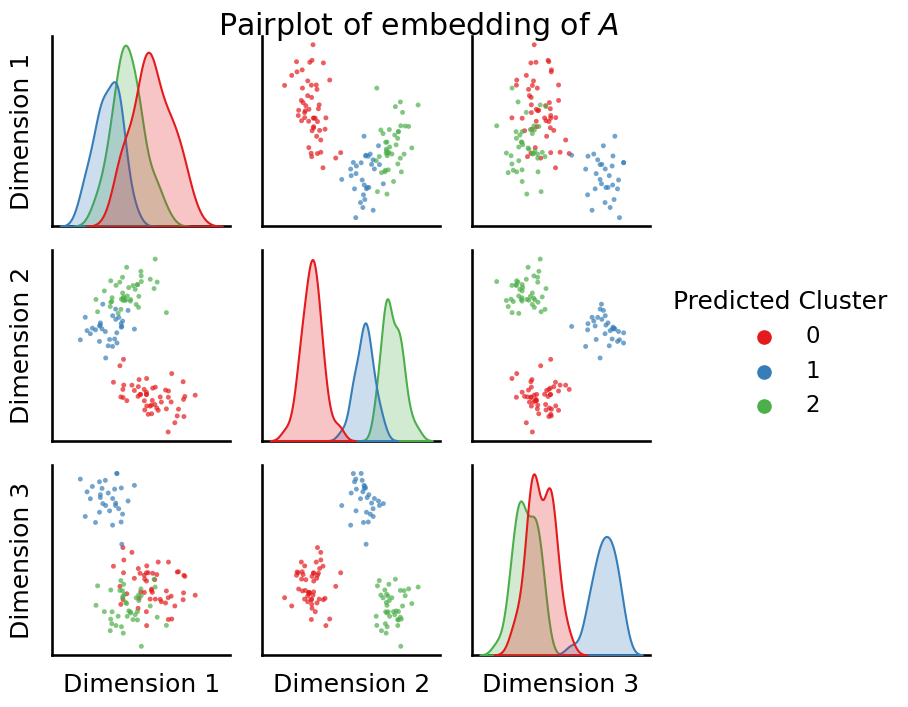

In [26]:
from graspologic.plot import pairplot

_ = pairplot(Xhat, labels=labels_kmeans, title="Pairplot of embedding of $A$", legend_name="Predicted Cluster")

You use these predicted cluster labels as the *predicted communities* for your Stochastic Block Model.

(ch14:unsup:eval)=
## Evaluation of unsupervised learning techniques

Since you have simulated data, you have the benefit of being able to evaluate the quality of your predicted community assignments to the true community assignments. However, there is an important caveat: your predictions might not *necessarily* align with your true labels. What we mean by this is that, your true communities might impart something meaningful about your dataset (here, they are just 0s, 1s, and 2s, but in a real dataset, they could be more meaningful things, like "School 1", "School 2", and "School 3"). Since we did not assume you knew *anything* about the communities when you ran your clustering, the predicted clusters will not have a correspondance with the original community names. In your example, this means that even though community 0 in the true labels and community 2 in the predicted labels encompass the same points, since the algorithm didn't know to call those points community 0, it just arbitrarily called them community 2. How can you proceed?

### The confusion matrix lets you visualize the homogeneity of predictions relative the true labels

To overcome this limitation for evaluation, we look at something called a confusion matrix. A **confusion matrix** is a matrix you use when you have two sets of labels for a group of data points, one of which you know to be the *true* labels, and another set of labels for which you do not know (yet) whether there is a correspondance with the true set of labels. If the set of true labels is one of $L$ possible values and the other set of labels take one of $K$ possible values, the confusion matrix will be:

| True label | Predicted label $1$ | ... | Predicted label $K$ |
| --- | --- | --- | --- |
| True label $1$ | #points(Predicted label $1$, true label $1$) | ... | #points(Predicted label $K$, true label $1$) |
| True label $2$ | #points(Predicted label $1$, true label $2$) | ... | #points(Predicted label $K$, true label $2$) |
| ... | ... | ... | ... |
| True label $L$ | #points(Predicted label $1$, true label $L$) | ... | #points(Predicted label $K$, true label $L$) |

You can compute and plot this matrix using a heatmap:

In [27]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix between the true labels z
# and the predicted labels labels_kmeans
cf_matrix = confusion_matrix(z, labels_kmeans)

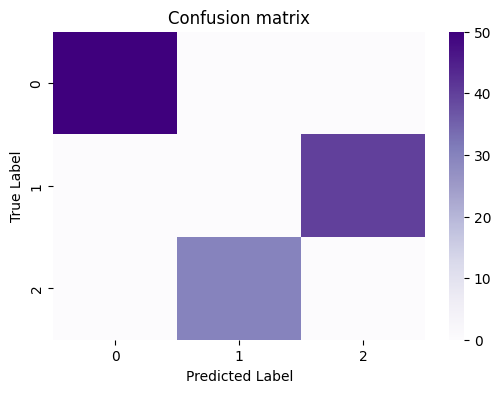

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.heatmap(cf_matrix, cmap=cmaps["sequential"], ax=ax)
ax.set_title("Confusion matrix")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label");

What you want to see, in general, in the confusion matrix for a "good" clustering is that the proportion of nodes which have a particular true label are "largely" assigned to the same predicted label. In this case, it's really obvious, because the predictions are virtually entirely (if not entirely) homogeneous, in that a single predicted label corresponds to a single true label. However, for posterity, a useful exercise is to get used to normalizing this confusion matrix, because things won't always be quite so obvious. You can do this by the counts by the total number of points assigned to a particular true label, which gives us the normalized confusion matrix:

In [29]:
cfm_norm = cf_matrix/cf_matrix.sum(axis=1)[:,None]

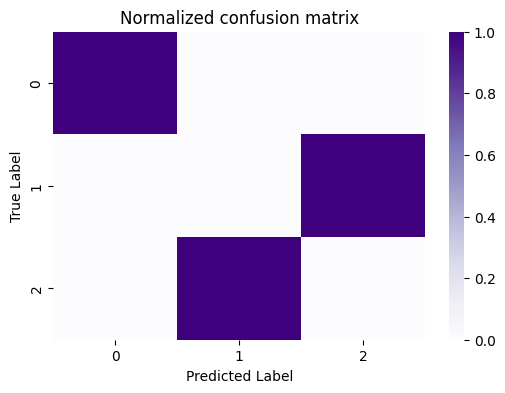

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
sns.heatmap(cfm_norm, cmap=cmaps["sequential"], ax=ax)
ax.set_title("Normalized confusion matrix")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label");

Now, it becomes clear that all of the points with a true label of $0$ are assigned to a predicted label of $1$, so on and so forth for all of the individual rows. So, how do you actually determine whether a confusion matrix indicates you did a good job with your predictions, and that your predictions and true labels "align"? 

(ch14:unsup:eval:ari)=
#### You can evaluate the homogeneity of the confusion matrix using the adjusted rand index (ARI)

For this purpose, we turn to the Rand Index, or RI. With the rand index, instead of looking at the confusion matrix itself *directly*, you look at all pairs of your data points. For a given pair of points in your dataset, these points can have true labels that are either the same, or different. Further, these points can have predicted labels that are either the same, or different. We introduce the following two concepts:
1. *Success*: Two points with the same true labels have the same predicted labels, or two points with different true labels have different predicted labels. This means that the two points *align homogeneously* across the true and predicted labels.
2. *Failure*: Two points with different true labels have the same predicted labels, or two points with the same true labels have different predicted labels. This means that the two points have a *heterogeneous alignment* across the true and predicted labels.
To compute the rand index, you simply take the ratio of successes divided by the total number of comparisons:
\begin{align*}
    RI &= \frac{\text{Successes}}{\text{Successes} + \text{Failures}}
\end{align*}

The Rand Index will have a value between $0$ or $1$, where a high value corresponds to a majority of the comparisons being successes (and hence, the true labels and predicted labels are homogeneous). 

There's a slight problem here when you want to use this number for evaluating a clustering. What if your true labels are disproportionate, in that one true label has a ton of data points, and the others only a small fraction of data points? By simply *guessing* that all of the points are from the biggest class, you could still end up with a pretty high RI. 

Consider, for instance, a simple example example in the very extreme case. Let's say that you have $10$ points, $9$ of which are in class $1$, and $1$ of which is in class $2$. What happens to the RI if you were to learn nothing about the structure of these points, and just guess that all of the points are in class $1$ without even looking at the data?

You can pick a single point from $10$ possible points, and then you compare this point to any of the other $9$ points. This means you will have $10 \cdot 9 = 90$ comparisons in total. Let's break down how these comparisons will go. You first choose the first point, which can be one of the $9$ items in class $1$, or the $1$ item in class $2$:
1. The first point is in class $1$:
    + The second point is also in class $1$: Of the remaining $9$ points you could choose for the second point, $8$ of them will have the same true label and predicted label as point $1$ (since you always guessed items were from class $1$). This means you will have $9$ (number of possible points which are from class $1$) times $8$ (number of remaining points which also have a true label of class $1$) $=72$ successes in which the point has a true label of $1$ and a predicted label of $1$.
2. The first point is in class $2$:
    + You have no successful comparisons when the first point is in class $2$, since the other points all have the same predicted label but a different true label.

This means that your RI is $\frac{72}{90} = 0.8$, which *feels* really high doesn't it, since it's closer to the highest possible value of $1$ than the lowest possible value of $0$?

To overcome this "weakness" in the RI, you instead "adjust" for the possible situations like this where the fractions of points with a particular true label are unevenly dispersed throughout the dataset. This "adjustment" to the RI is aptly named: it is called the **Adjusted Rand Index** (ARI) {cite:p}`Rand1971Dec`. You can compute the ARI using `sklearn` easily:

In [31]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(z, labels_kmeans)

In [32]:
print("ARI(predicted communities, true communities) = {}".format(ari_kmeans))

ARI(predicted communities, true communities) = 1.0


(ch14:unsup:eval:silhouette)=
#### The Silhouette score allows us to compare unsupervised clustering quality

The Silhouette score {cite:p}`Rousseeuw1987Nov` will provide you with a statistic that you can compare across clusterings with different numbers of clusters. At an extremely high level, the Silhouette score asks the simple question, "How similar are the nodes in the same cluster from other clusters?" If for a given number of clusters, and those clusters are *spatially unique* (there aren't too many clusters for what is really just a single blob of points, and likewise, there aren't single clusters doing a job that might be better served by two clusters), then the Silhouette score will, ideally, be higher. We mention this statistic in particular because it can be reasonably used with *any* unsupervised learning technique, and won't pose restrictions on the unsupervised technique chosen, for instance. Other popular techniques, such as the Bayesian Information Criterion (BIC), can *only* be computed when assumptions are made about the unsupervised learning technique used, but you can read about them on your own time for more information if you want.

To compute the Silhouette score, you need some basic ingredients first. You have data points $x_i$ for $i$ from $1$ to $n$, the estimates of latent positions of the nodes in your network, and you have predicted community labels $z_i$, which assign each node to one of $K$ possible clusters. We will call the set of nodes assigned to the cluster with label $k$ the set $C_k$, which is just a collection of indexes of nodes in the network. For instance, if the network had $10$ nodes and the total number of clusters you were considering was two, where the first five nodes were assigned to cluster $1$ and the second five nodes were assigned to cluster $2$, then $C_1 = \{1,2,3,4,5\}$, and $C_2 = \{6,7,8,9,10\}$. We will call the total number of nodes which are in community $k$ the quantity $n_k$. You have the following two ingredients:

1. The dissimilarity of a node $i$ from the other nodes in its community: You compute the average distance between the estimate of the latent position for the node $i$, and all of the other nodes which are in the same community as node $i$. If you assume that the node $i$ is in community $k$, this is just the quantity:
\begin{align*}
    a_i &= \frac{1}{n_k - 1} \sum_{j \in C_k, i \neq j}||\vec x_i - \vec x_j||
\end{align*}
where $||x - y||$ is the Euclidean distance between two vectors $\vec x_i$ and $\vec x_j$. The sum just indicates that you are computing distances over all of the other nodes in community $k$ which are *not* node $i$ (node $i$ is in community $k$, so there are $n_k - 1$ of these other points), and then you take the average by dividing by the number of points in community $k$ which are *not* node $i$.
2. The dissimilarity of a node $i$ from the other nodes in a different community: We compute the average distance between the estimate of the latent position for the node $i$, and this time all of the other nodes which are in some other community $l$ from node $i$. If you assume that the node $i$ is in community $k$, this is just the quantity:
\begin{align*}
    b_{il} &= \frac{1}{n_l} \sum_{j \in C_l}||\vec x_i - \vec x_j||
\end{align*}
Node $i$ is in community $k$, so this time, you don't need to worry about excluding the node $i$ from your comparisons (and, you can compare to every other node in $C_l$).
3. The *other* community that node $i$ is most similar to: This is just the community for which has the *smallest* dissimilarity from node $i$, and hence, is the *best alternative cluster* that you could have assigned $i$ to:
\begin{align*}
    d_i &= \min_{l\text{ is a community}}b_{il}
\end{align*}
And the Silhouette of node $i$ in community $k$ is just:
\begin{align*}
    s_i &= \begin{cases}
        \frac{d_i - a_i}{\max(a_i, d_i)} & n_k > 1 \\
        0 & n_k = 1
    \end{cases}
\end{align*}
In words, if the Silhouette $s_i$ is near $1$, then the node $i$ is much more similar to points which are in its own cluster than the best alternative, since since a value near $1$ can only happen if $d_i$ is much bigger than $a_i$. Further, if the Silhouette is near $-1$, then the node $i$ is more similar to points which are in a neighboring cluster which is not the one it was assigned to. This is because negative values can only happen if node $i$s dissimilarity from other points in its cluster, $a_i$, is higher than its dissimilarity from other points in another cluster, $d_i$. 

You get the silhouette score for however many clusters you are trying $K$ by just taking the average of the node-wise silhouettes:
\begin{align*}
    S_K &= \frac{1}{n} \sum_{i = 1}^n s_i
\end{align*}

## References

```{bibliography}
:filter: docname in docnames
:style: unsrt
```